# MNIST Dynamic Filter Classification - Result

**Note**: This notebook is desinged to run on CPU (no GPU) runtime.

**[MDR-01]**

Install Flax and Optax

In [1]:
%%bash
pip install -q flax optax
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.0
jax                           0.3.17
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[MDR-02]**

Import modules.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from tensorflow.keras.datasets import mnist

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state, checkpoints

plt.rcParams.update({'font.size': 12})

**[MDR-03]**

Download the MNIST dataset and store into NumPy arrays.

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

**[MDR-04]**

Convert test images/labels to DeviceArray objects.

In [4]:
test_images = jnp.asarray(test_images)
test_labels = jnp.asarray(test_labels)

**[MDR-05]**

Define CNN model with a single convolutional filter layer.

In [5]:
class SingleLayerCNN(nn.Module):
  @nn.compact
  def __call__(self, x, get_filter_output=False, get_pooling_output=False):
    x = x.reshape([-1, 28, 28, 1])
    x = nn.Conv(features=16, kernel_size=(5, 5), name='ConvLayer')(x)
    x = nn.relu(x)
    if get_filter_output:
        return x
    x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    if get_pooling_output:
        return x
    x = x.reshape([x.shape[0], -1]) # Flatten
    x = nn.Dense(features=1024)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    x = nn.softmax(x)
    return x

**[MDR-06]**

Initialize parameters and create a TrainState object.

In [6]:
variables = SingleLayerCNN().init(random.PRNGKey(0), test_images[0:1])

state = train_state.TrainState.create(
    apply_fn=SingleLayerCNN().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.001))

**[MDR-07]**

Mount Google Drive content.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**[MDR-08]**

Check contents of the checkpoint directory.

In [8]:
!ls -lh '/content/gdrive/My Drive/checkpoints/'

total 37M
-rw------- 1 root root 37M Oct  2 08:57 SingleLayerCNN_checkpoint_16


**[MDR-09]**

Restore TrainState object from the checkpoint file.

In [9]:
state = checkpoints.restore_checkpoint(
    ckpt_dir='/content/gdrive/My Drive/checkpoints',
    prefix='SingleLayerCNN_checkpoint_',
    target=state)

**[MDR-10]**

Retrieve information using the restored TrainState object.

In [10]:
filter_vals = jax.device_get(state.params['ConvLayer']['kernel'])

filter_output = jax.device_get(
    state.apply_fn({'params': state.params}, test_images[:9],
                   get_filter_output=True))

pooling_output = jax.device_get(
    state.apply_fn({'params': state.params}, test_images[:9],
                   get_pooling_output=True))

**[MDR-11]**

Show sample images from the convolutional filters.

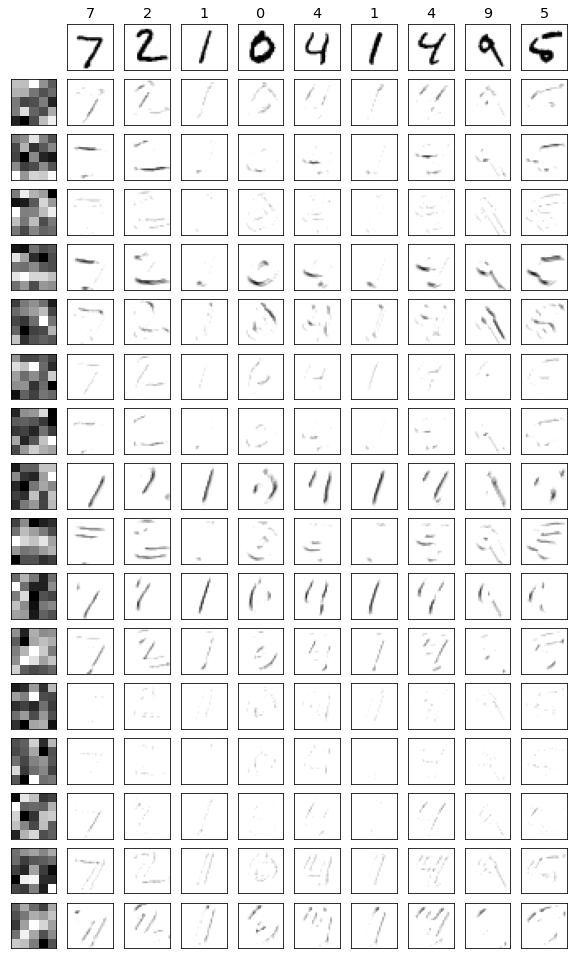

In [11]:
num_filters = 16
fig = plt.figure(figsize=(10, num_filters+1))
v_max = np.max(filter_output)

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i], cmap=plt.cm.gray_r)

for i in range(9):
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(test_labels[i]))
    subplot.imshow(test_images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(filter_output[i,:,:,f], 
                       vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

**[MDR-12]**

Show sample images from the pooling layer.

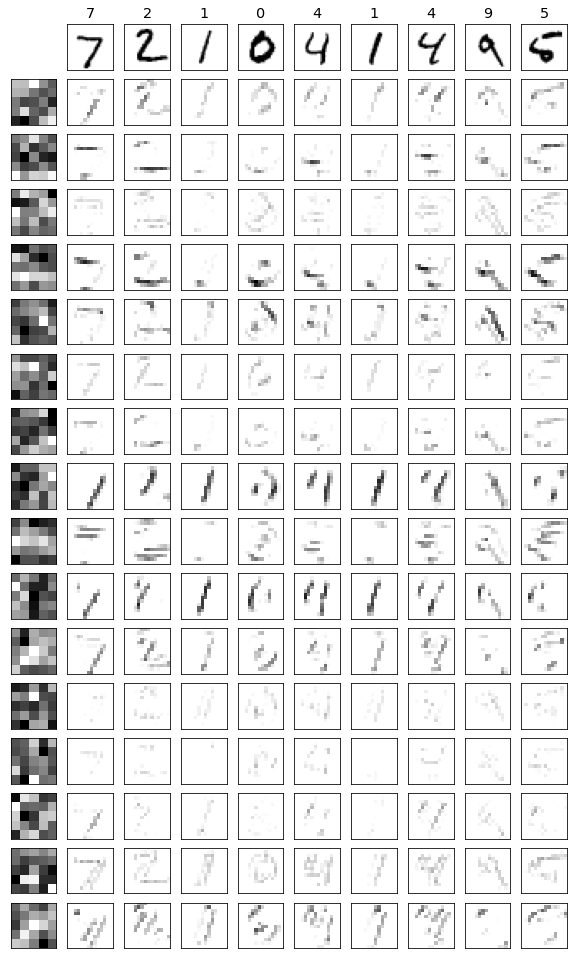

In [12]:
num_filters = 16
fig = plt.figure(figsize=(10, num_filters+1))
v_max = np.max(pooling_output)

for i in range(num_filters):
    subplot = fig.add_subplot(num_filters+1, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(num_filters+1, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(test_labels[i]))
    subplot.imshow(test_images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

    for f in range(num_filters):
        subplot = fig.add_subplot(num_filters+1, 10, 10*(f+1)+i+2)
        subplot.set_xticks([])
        subplot.set_yticks([])
        subplot.imshow(pooling_output[i,:,:,f], 
                       vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

**[MDR-13]**

Show sample prediction results for wrong predictions.

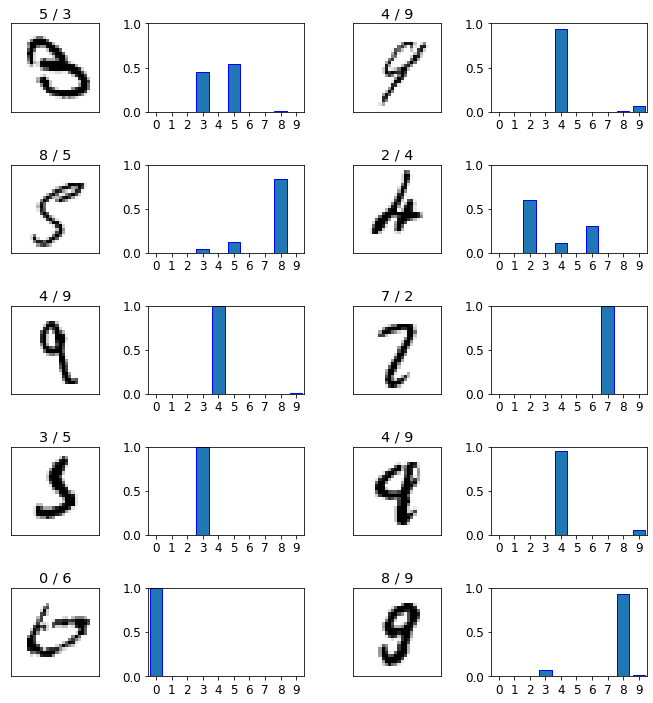

In [13]:
predictions = jax.device_get(
    state.apply_fn({'params': state.params}, test_images))

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.1, hspace=0.6)

c = 0
for i in range(len(predictions)):
    prediction = np.argmax(predictions[i])
    actual = np.argmax(test_labels[i])
    if prediction == actual:
        continue
    
    image = jax.device_get(test_images[i])
    prediction_vals = predictions[i]

    subplot = fig.add_subplot(5, 4, c*2+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('{} / {}'.format(prediction, actual))
    subplot.imshow(image.reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)
    subplot = fig.add_subplot(5, 4, c*2+2)
    subplot.set_xticks(range(10))
    subplot.set_xlim([-0.5, 9.5])
    subplot.set_ylim([0, 1])
    subplot.bar(range(10), prediction_vals, align='center', edgecolor='b')
    c += 1
    if c == 10:
        break